In [1]:
# === Setup ===
!pip install transformers torchtext --quiet

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import BertTokenizer, BertModel
from google.colab import drive

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# === Mount and Load Data ===
drive.mount('/content/drive')
# !unzip "/content/drive/MyDrive/ECS 189G/stage_4_data.zip" -d /content/

DATA_DIR = "/content/stage_4_data/text_classification"
RESULTS_DIR = "/content/stage_4_result"
os.makedirs(RESULTS_DIR, exist_ok=True)

def load_classification_data(split_dir):
    data = []
    for label_name, label_val in [('pos', 1), ('neg', 0)]:
        label_dir = os.path.join(split_dir, label_name)
        for fname in os.listdir(label_dir):
            fpath = os.path.join(label_dir, fname)
            if os.path.isfile(fpath) and fname.endswith('.txt'):
                with open(fpath, 'r', encoding='utf-8') as f:
                    text = f.read().strip()
                data.append({'text': text, 'label': label_val})
    return data

# Load data splits
train_data = load_classification_data(os.path.join(DATA_DIR, "train"))
test_data  = load_classification_data(os.path.join(DATA_DIR, "test"))


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# === BERT Tokenizer and Embedding Function ===
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased').to(device)
bert.eval()

def prepare_bert_embeddings(dataset_list, tokenizer, max_len=128, batch_size=32):
    texts = [d['text'] for d in dataset_list]
    labels = [d['label'] for d in dataset_list]

    encodings = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )

    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    embeddings = []
    with torch.no_grad():
        for i in range(0, input_ids.size(0), batch_size):
            batch_ids = input_ids[i:i+batch_size]
            batch_mask = attention_mask[i:i+batch_size]
            outputs = bert(input_ids=batch_ids, attention_mask=batch_mask)
            cls_batch = outputs.last_hidden_state[:, 0, :]  # CLS token
            embeddings.append(cls_batch)

    X = torch.cat(embeddings, dim=0)
    y = torch.tensor(labels).to(device)
    return TensorDataset(X, y)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


In [3]:
# === Prepare DataLoaders ===
print("working")
train_dataset = prepare_bert_embeddings(train_data, tokenizer)
print("working")
test_dataset  = prepare_bert_embeddings(test_data, tokenizer)
print("working")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print("working")
test_loader  = DataLoader(test_dataset, batch_size=32)
print("working")


working
working
working
working
working


In [47]:
import torch
import torch.nn as nn

class BertLSTMClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=24, num_layers=1, num_classes=2, dropout=0.2):
        super(BertLSTMClassifier, self).__init__()

        # Smaller LSTM to reduce overfitting
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0  # Keep as 0 for single layer
        )

        # Much simpler classifier - direct from LSTM to output
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, seq_len=1, input_dim)
        _, (hn, _) = self.lstm(x)  # hn shape: (num_layers, batch, hidden_dim)
        x = hn[-1]  # last layer hidden state
        x = self.dropout(x)
        return self.fc(x)

# Simpler model with less capacity
model = BertLSTMClassifier(
    hidden_dim=24,      # Much smaller than your 48
    dropout=0.2         # Less aggressive dropout
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,            # Lower learning rate
    weight_decay=5e-4   # Moderate weight decay
)

In [48]:
train_losses = []
train_accuracies = []

def train(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

# === Run Training ===
epochs = 100
for epoch in range(1, epochs + 1):
    loss, acc = train(model, train_loader)
    train_losses.append(loss)
    train_accuracies.append(acc)
    print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")


Epoch 1: Loss = 0.5890, Accuracy = 0.7046
Epoch 2: Loss = 0.4810, Accuracy = 0.7746
Epoch 3: Loss = 0.4586, Accuracy = 0.7850
Epoch 4: Loss = 0.4469, Accuracy = 0.7928
Epoch 5: Loss = 0.4421, Accuracy = 0.7958
Epoch 6: Loss = 0.4331, Accuracy = 0.8003
Epoch 7: Loss = 0.4308, Accuracy = 0.8014
Epoch 8: Loss = 0.4264, Accuracy = 0.8040
Epoch 9: Loss = 0.4215, Accuracy = 0.8058
Epoch 10: Loss = 0.4194, Accuracy = 0.8085
Epoch 11: Loss = 0.4156, Accuracy = 0.8098
Epoch 12: Loss = 0.4110, Accuracy = 0.8104
Epoch 13: Loss = 0.4080, Accuracy = 0.8123
Epoch 14: Loss = 0.4069, Accuracy = 0.8151
Epoch 15: Loss = 0.4036, Accuracy = 0.8148
Epoch 16: Loss = 0.4019, Accuracy = 0.8169
Epoch 17: Loss = 0.3981, Accuracy = 0.8183
Epoch 18: Loss = 0.3941, Accuracy = 0.8196
Epoch 19: Loss = 0.3932, Accuracy = 0.8198
Epoch 20: Loss = 0.3911, Accuracy = 0.8216
Epoch 21: Loss = 0.3876, Accuracy = 0.8234
Epoch 22: Loss = 0.3860, Accuracy = 0.8250
Epoch 23: Loss = 0.3850, Accuracy = 0.8264
Epoch 24: Loss = 0.3

In [49]:
from sklearn.metrics import classification_report, confusion_matrix

def test_model(model, test_loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            pred = torch.argmax(logits, dim=1)
            preds.extend(pred.cpu().numpy())
            targets.extend(y.cpu().numpy())

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds)
    precision = precision_score(targets, preds)
    recall = recall_score(targets, preds)

    print("\n=== Test Set Evaluation ===")
    print(f"Accuracy  : {acc:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(targets, preds, target_names=["Negative", "Positive"]))

# ✅ Run Test Evaluation
test_model(model, test_loader)



=== Test Set Evaluation ===
Accuracy  : 0.8101
F1 Score  : 0.8128
Precision : 0.8014
Recall    : 0.8244

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.80      0.81     12500
    Positive       0.80      0.82      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



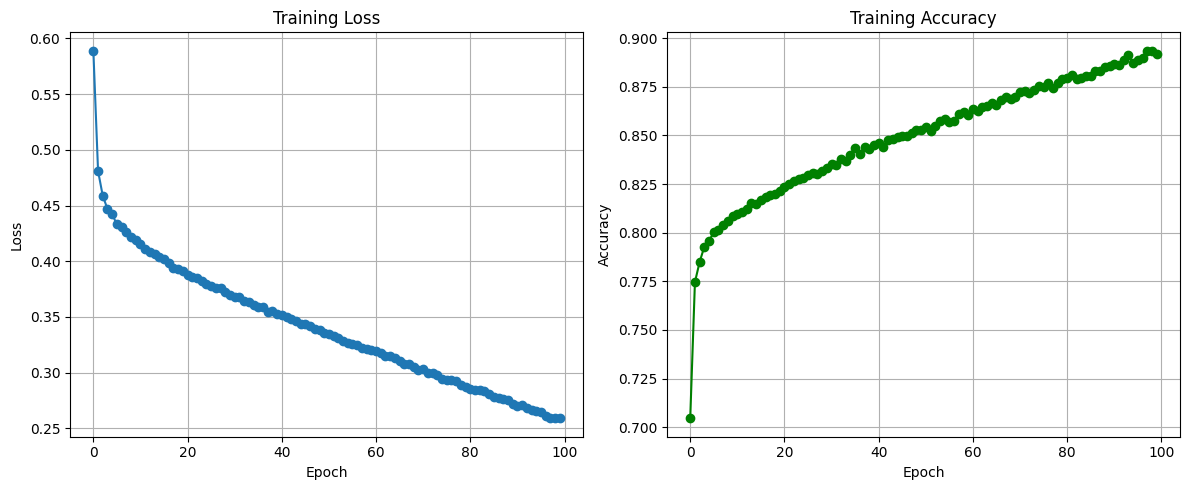

In [50]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green', label='Train Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()
